# In this notebook, we will tackle the Titanic Kaggle Competition by following a complete data science workflow. 
# This includes thorough :
## I. Simple approach
-    Dependencies and importation
- 1. data preprocessing : handling missing values
- 2. Transform data
- 3. Data visualisation
- 4. Labelize
- 5. Process Workflow
- 6. Hypertuning
- 7. Model training
- 8. Submit prediction

## II. KNNImputer fillna method
- 1) transform our data like in the first part of this not book without replacing nan values
- 2) labelize our data without replacing Nan values
- 3) the use the KnnImputer function to fillna with nearest neighbors
- 4) model prediction


## The goal is to build a predictive model to determine the survival likelihood of passengers based on their characteristics. By the end of this notebook, we aim to achieve a well-performing model while gaining deeper insights into the factors that influenced survival on the Titanic."

# 1. Install dependencies

### Automatic reload

In [1]:
%load_ext autoreload
%autoreload 2

### Dependencies

In [128]:
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sys
sys.path.append("../..")
import utilities_plot as up

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


### Dataset importation : Take a look at the data

In [75]:
## datasets importation

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(len(train))
train.head(5)

891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1. Missing Values

In [78]:
train.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [79]:
test.isna().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

/var/folders/vc/kyc23w1d2xv71xlg1pxxvq580000gn/T/ipykernel_72360/2433110067.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(vect_na_train, palette= "Oranges", ax = axes[0])
/var/folders/vc/kyc23w1d2xv71xlg1pxxvq580000gn/T/ipykernel_72360/2433110067.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(vect_na_test, palette= "Oranges", ax = axes[1])


Text(0.5, 0, 'Columns')

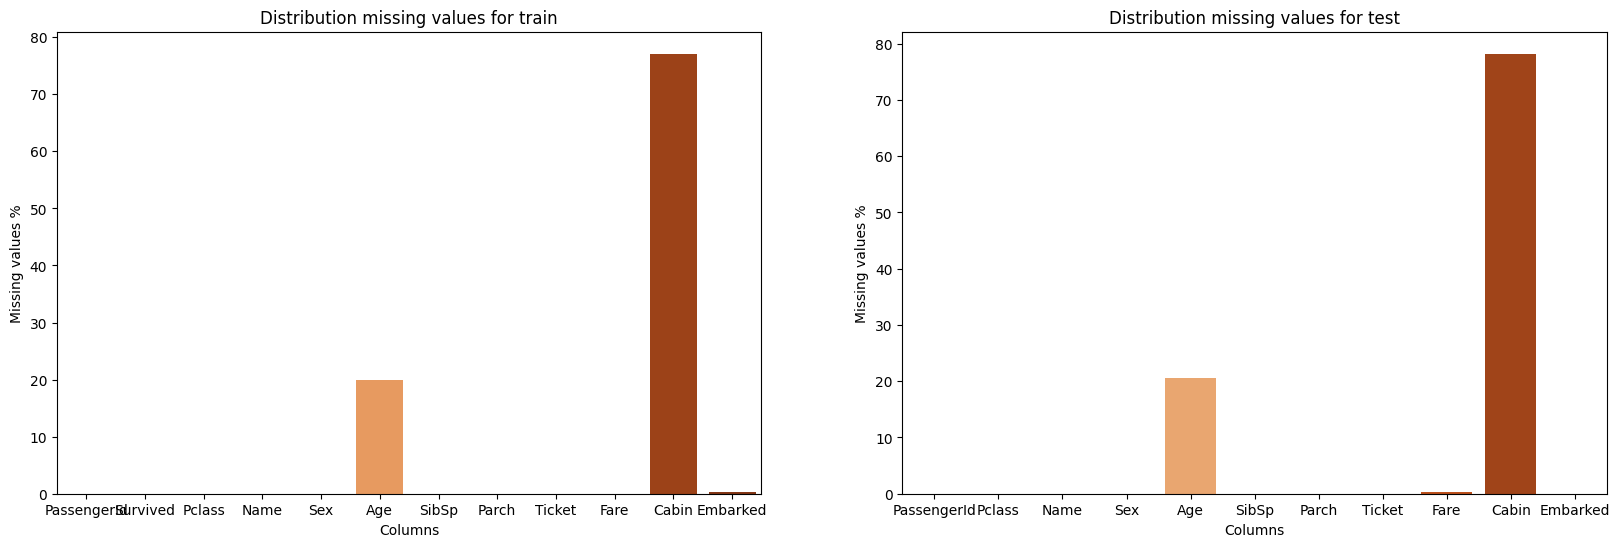

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

vect_na_train = (train.isna().sum()/len(train))*100
vect_na_test = (test.isna().sum()/len(test))*100

sb.barplot(vect_na_train, palette= "Oranges", ax = axes[0])
axes[0].set_title('Distribution missing values for train')
axes[0].set_ylabel('Missing values %')
axes[0].set_xlabel('Columns')

sb.barplot(vect_na_test, palette= "Oranges", ax = axes[1])
axes[1].set_title('Distribution missing values for test')
axes[1].set_ylabel('Missing values %')
axes[1].set_xlabel('Columns')


### Function to automatically fulfill missing data : 
- majority for Embarked
- mean for Age
- new value "Unk" for Cabin beacause more than 70% missing values

In [126]:
def fill_na_process(data: pd.DataFrame):    
    """fillna function

    Args:
        data (pd.DataFrame): 
            the dataframe we want to handle missing values

    Returns:
        pd.DataFrame: 
            dataframe without missing values
    """
    copy_data = data.copy()
    print("[INFO] : fillna...")
    
    copy_data.Age      = copy_data.Age.fillna(data.Age.mean())   
    copy_data.Fare     = copy_data.Fare.fillna(data.Fare.mean())
    copy_data.Embarked = copy_data.Embarked.fillna('S')  
    
    print("[INFO] : end fillna", end="\n")
    
    return copy_data

# 2. Transform data

Transformations :
- Cabin  : we keep the first letter, ex C85 -> C | Nan -> N
- Ticket : same as Cabin
- Title  : we will keep the Title prefix

Create bin :
bool if we want to create categories :
- Age : 4 categories : <12 -> Children | 13-20 -> Teenage | 21-40 -> Adult | >41 -> Elder
- Fare : 4 categories : 'Low_fare', 'median_fare', 'Average_fare', 'high_fare'
- then we create dummies for : "Sex", "Title", "Age_Range", "Embarked", "Fare_Range"

In [87]:
def transfo_titanic(data: pd.DataFrame, create_bin: bool):
    """Transform data

    Args:
        data (pd.DataFrame): 
            the dataframe we want to transform
        
        create_bin (bool): 
            if yes r not we want ot create categories

    Returns:
        pd.DataFrame: 
            transform dataframe
    """
    
    data_copy = data.copy()
    print("[INFO] : transform data...")
    # we regroupe the first char for Cabin and Ticket. For Cabin the "N" char represent NaN value
    # there is so many NaN values in Cabin that we keep it as a label
    data_copy['Cabin_Prefix']  = data_copy['Cabin'].apply(lambda x: str(x)[0])  # 0 for the first char
    data_copy['Ticket_Prefix'] = data_copy['Ticket'].apply(lambda x: x[:1])  
    
    # We extract the title of a person and we keep the most significant ['Mr', 'Miss', 'Mrs', 'Master']
    data_copy['Title'] = data_copy['Name'].apply(lambda txt : txt.split()[1].replace('.', ''))
    data_copy['Title'] = data_copy['Title'].apply(lambda txt: txt if txt in ['Mr', 'Miss', 'Mrs', 'Master'] else 'unk')
        
    # if we want to create categories for Age and Fare
    if create_bin:
        
        data_copy['Age_Range']  = pd.cut(data_copy['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])
        data_copy['Fare_Range'] = pd.cut(data_copy['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])
        
        data_copy = pd.get_dummies(data_copy, columns = ["Sex","Title","Age_Range","Embarked", "Fare_Range"],
                             prefix=["Sex","Title","Age_type","Embarked_type", "Fare"], dummy_na=False)

        data_copy = data_copy.drop(['PassengerId', 'Name', 'Age', 'Ticket', 'Fare', 'Cabin', "Ticket_Prefix", "Cabin_Prefix"], axis = 1)
      
    else:  
        data_copy = data_copy.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
        
    print("[INFO] : end transforming", end="\n")
        
    return data_copy

In [77]:
train_transform = fill_na_process(train)
train_transform = transfo_titanic(train_transform, False)

test_transform = fill_na_process(test)
test_transform = transfo_titanic(test_transform, False)

train_transform.head(5)

[INFO] : fillna...
[INFO] : end fillna
[INFO] : transform data...
[INFO] : end transforming
[INFO] : fillna...
[INFO] : end fillna
[INFO] : transform data...
[INFO] : end transforming


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Prefix,Ticket_Prefix,Title
0,0,3,male,22.0,1,0,7.2500,S,n,A,Mr
1,1,1,female,38.0,1,0,71.2833,C,C,P,Mrs
2,1,3,female,26.0,0,0,7.9250,S,n,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,C,1,Mrs
4,0,3,male,35.0,0,0,8.0500,S,n,3,Mr


# 3. Data Visualisation

### repartition depending on survived

/var/folders/vc/kyc23w1d2xv71xlg1pxxvq580000gn/T/ipykernel_72360/543493409.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(survived, palette= "GnBu_r", ax = axes[0])
/var/folders/vc/kyc23w1d2xv71xlg1pxxvq580000gn/T/ipykernel_72360/543493409.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(no_survived, palette= "GnBu", ax = axes[1])


Text(0.5, 0, 'Sex')

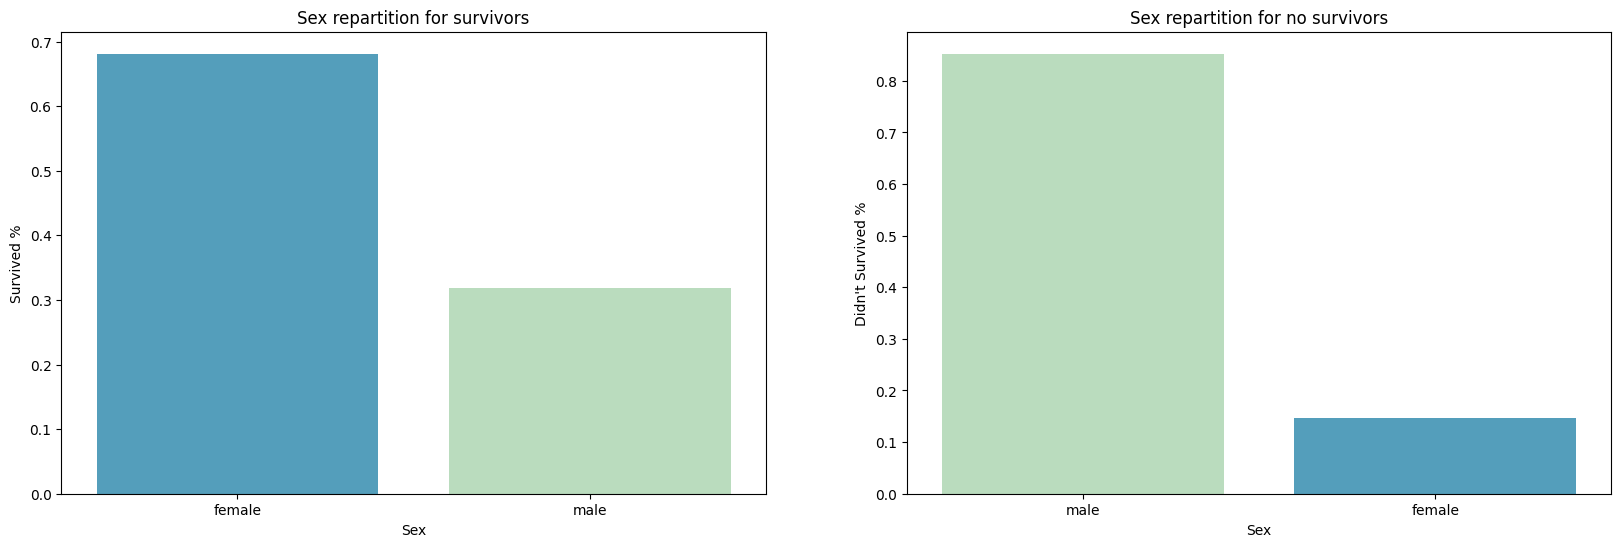

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

survived    = train_transform[train_transform.Survived == 1]["Sex"].value_counts(normalize= True)
no_survived = train_transform[train_transform.Survived == 0]["Sex"].value_counts(normalize= True)

sb.barplot(survived, palette= "GnBu_r", ax = axes[0])
axes[0].set_title('Sex repartition for survivors')
axes[0].set_ylabel('Survived %')
axes[0].set_xlabel('Sex')

sb.barplot(no_survived, palette= "GnBu", ax = axes[1])
axes[1].set_title('Sex repartition for no survivors')
axes[1].set_ylabel("Didn't Survived %")
axes[1].set_xlabel('Sex')

### Function density display

Text(0.5, 0, 'Fare')

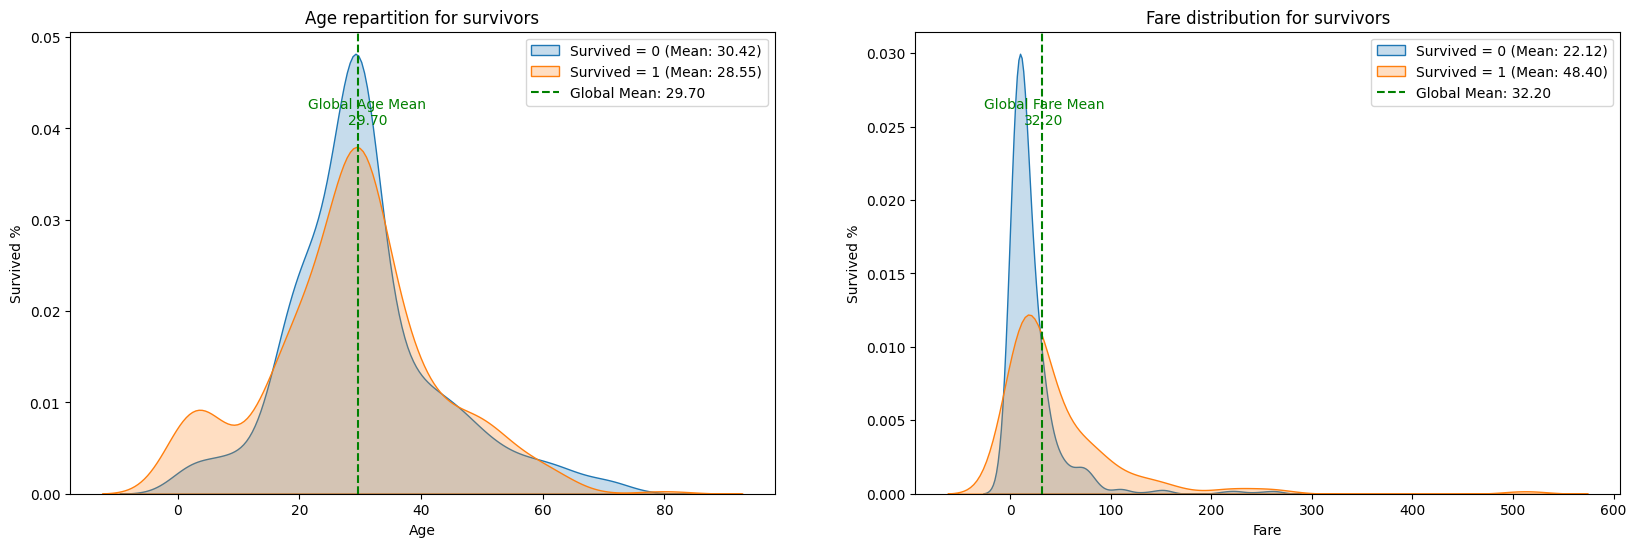

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

up.density_on_target(train_transform, "Survived", "Age", ax= axes[0])
axes[0].set_title('Age repartition for survivors')
axes[0].set_ylabel('Survived %')
axes[0].set_xlabel('Age')

up.density_on_target(train_transform, "Survived", "Fare", ax= axes[1])
axes[1].set_title('Fare distribution for survivors')
axes[1].set_ylabel('Survived %')
axes[1].set_xlabel('Fare')

array([<Axes: title={'center': 'Survived = 0\nMean: 30.42'}, xlabel='Age', ylabel='Density'>,
       <Axes: title={'center': 'Survived = 1\nMean: 28.55'}, xlabel='Age'>],
      dtype=object)

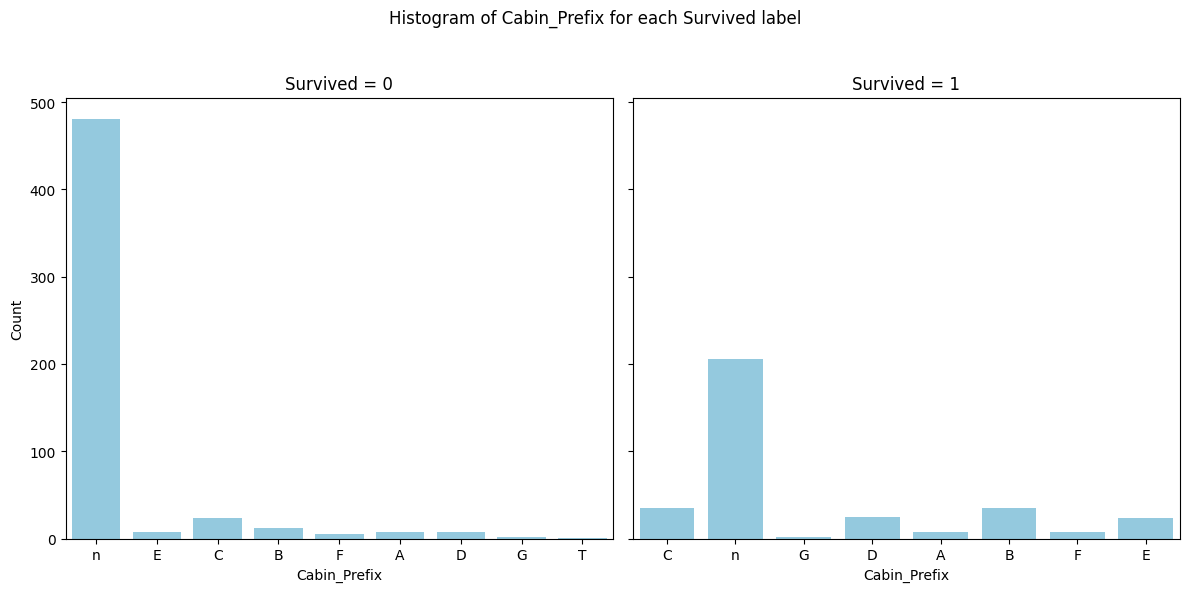

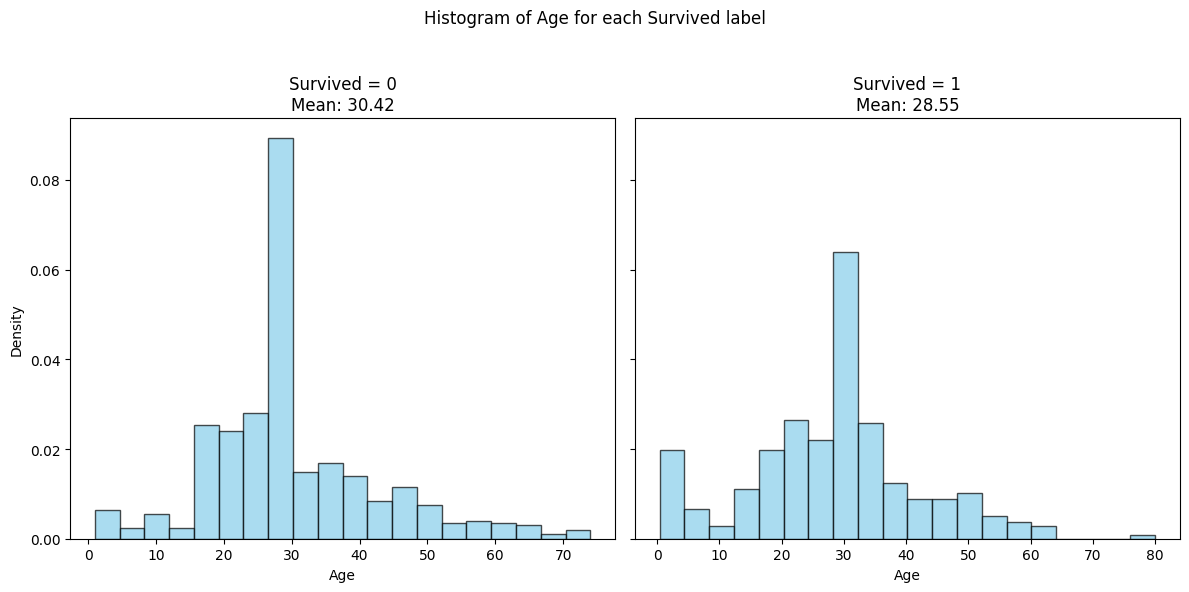

In [131]:
up.histogram_on_target(train_transform, "Survived", "Cabin_Prefix", bins = 20)
up.histogram_on_target(train_transform, "Survived", "Age", bins = 20)

/Users/avicenne/Documents/python/kaggle-projects/classification-projects/Titanic/../../utilities_plot.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=target_name, y=column_name, data=data, ax=ax, palette="pastel")


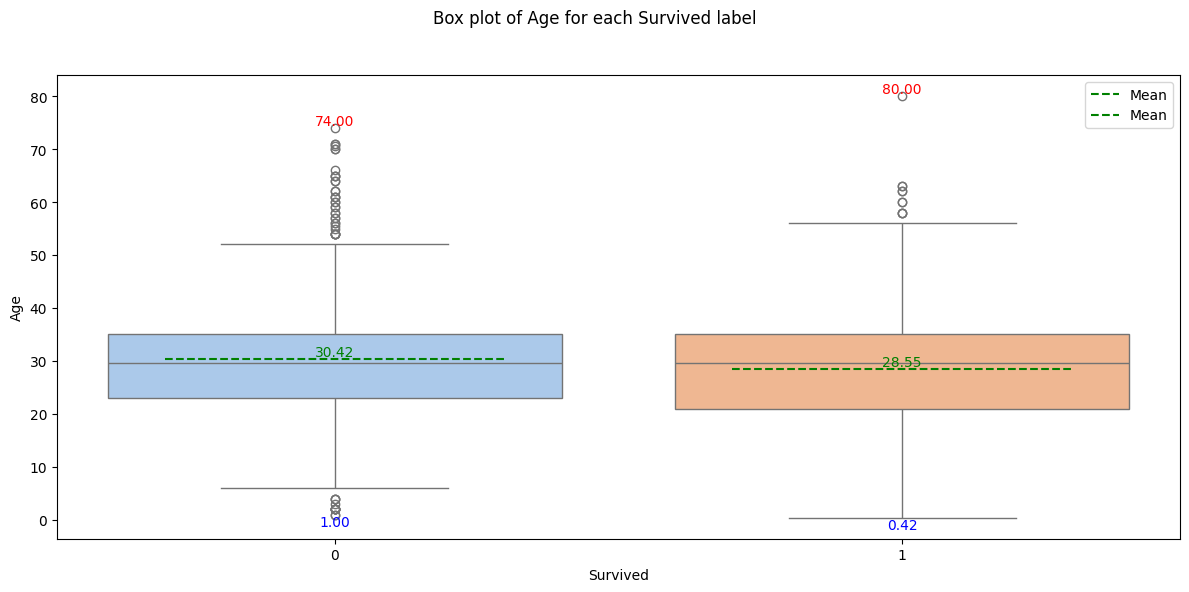

(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Survived', ylabel='Age'>)

In [132]:
up.boxplot_on_target(train_transform, "Survived", "Age")

/Users/avicenne/Documents/python/kaggle-projects/classification-projects/Titanic/../../utilities_plot.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x=target_name, y=column_name, data=data, ax=ax, palette="pastel")


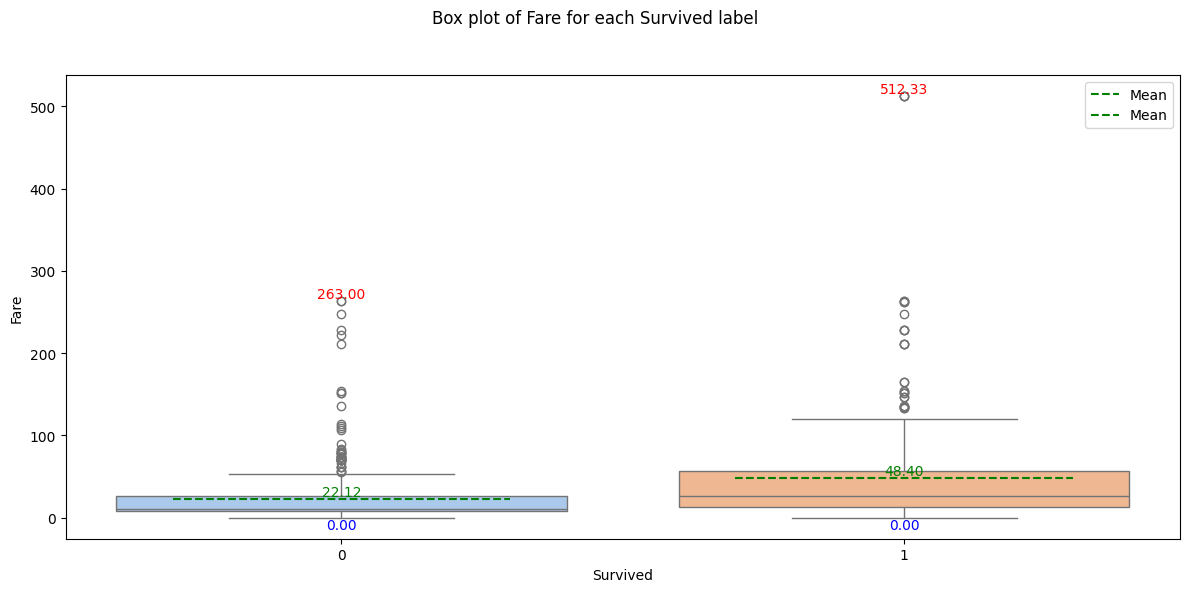

(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Survived', ylabel='Fare'>)

In [133]:
up.boxplot_on_target(train_transform, "Survived", "Fare")

# 4. labelize data

### Function to labelize data

In [30]:
def labelize_data(train: pd.DataFrame, test: pd.DataFrame, display_corr_map: bool):
    """labelize num numeric values

    Args:
        train (pd.DataFrame)
        test (pd.DataFrame)
        
        display_heat_map (bool):
            if we want to display corelation heat map

    Returns:
        _type_: _description_
    """
    
    # we save the lable we will predict 
    y_train = train.Survived
    
    # label we need to labelize
    need_labelize = [label for label in train.columns if train[label].dtype =='object']
    encode = LabelEncoder()
        
    print("[INFO] : labelize...")
    for lab in need_labelize:
        print("need labelize :", lab)
        encode.fit(train[lab])
        train[lab] = encode.transform(train[lab])
        test[lab] = encode.transform(test[lab])
        
    print("[INFO] : end labelize", end="\n")
    
    # correlation
    correlation = train.corr()
    sb.heatmap(correlation, cmap = 'magma')
    if display_corr_map:
        plt.show()
    
    return train, test, y_train

# 5. Complete workflow

Finally we can process the whole data

[INFO] : fillna...
[INFO] : end fillna
[INFO] : transform data...
[INFO] : end transforming
[INFO] : fillna...
[INFO] : end fillna
[INFO] : transform data...
[INFO] : end transforming
[INFO] : labelize...
need labelize : Sex
need labelize : Embarked
need labelize : Cabin_Prefix
need labelize : Ticket_Prefix
need labelize : Title
[INFO] : end labelize


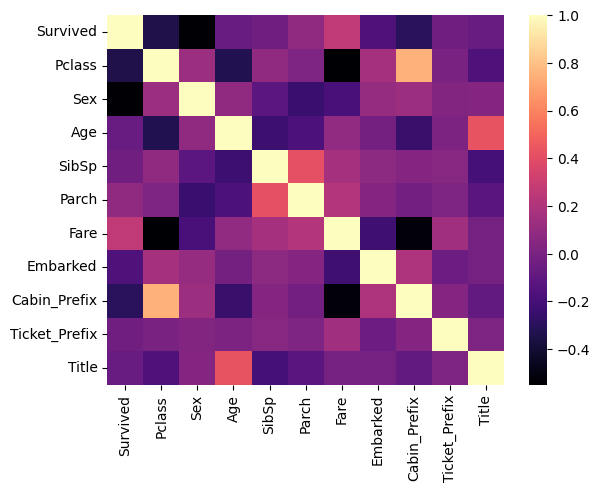

len x_train:  (623, 10)
len x_val:  (268, 10)
len label_train:  (623,)
len label_val:  (268,)


In [31]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Id = test.PassengerId

# transform
train_transform = fill_na_process(train)
train_transform = transfo_titanic(train_transform, False)

test_transform = fill_na_process(test)
test_transform = transfo_titanic(test_transform, False)

# we labelize
train_transform, test_transform, y_train= labelize_data(train_transform, test_transform, display_corr_map= True)

train_transform = train_transform.drop(['Survived'], axis = 1)

# we split
x_train, x_val, y_train, y_val = train_test_split(train_transform, y_train, test_size = 0.3, random_state = 42)

print("len x_train: ",x_train.shape)
print("len x_val: ", x_val.shape)
print("len label_train: ",y_train.shape)
print("len label_val: ", y_val.shape)
    

# 6. Find optimal hyperparams

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


def get_hyppars_(model, params, n_iter, cv, scoring, n_jobs,
                random_state, x_train, y_train, x_val, y_val):

    # Initialisation RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=params, 
                                       n_iter=n_iter, cv=cv,
                                       scoring=scoring, n_jobs=n_jobs, random_state=42)

    # Train
    random_search.fit(x_train, y_train)

    # Print
    print("Best parameters found using random_search: ", random_search.best_params_)
    print("Best accuracy score found during search using random_search: ", random_search.best_score_)

In [37]:
from catboost import CatBoostClassifier

models = [CatBoostClassifier(verbose=0)]
params = [{
            'iterations': randint(80, 1000),
            'learning_rate': uniform(0.01, 0.28),
            'depth': randint(1, 10)
                        }]

for i in range(len(models)):
    print('for :', models[i])
    get_hyppars_(models[i], params[i], n_iter = 30, cv=10, scoring = 'accuracy', n_jobs=-1,
                 random_state=0, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

for : <catboost.core.CatBoostClassifier object at 0x16a74ab40>
Best parameters found using random_search:  {'depth': 8, 'iterations': 142, 'learning_rate': 0.2383291999673536}
Best accuracy score found during search using random_search:  0.8491039426523297


# 7. Model prediction

## Function to train model

In [49]:
def train_model(model, cross_val: bool, x_train : pd.DataFrame = x_train, y_train : pd.Series = y_train, 
                x_val : pd.DataFrame = x_val, y_val : pd.Series = y_val):
    
    """train model

        Args:
            model (_type_): 
                the model we want
            cross_val (bool): 
                if we want the cross val
                
            x_train (pd.DataFrame, optional): 
                Defaults to x_train.
                
            y_train (pd.Series, optional): 
                Defaults to y_train.
                
            x_val (pd.DataFrame, optional):
                Defaults to x_val.
                
            y_val (pd.Series, optional):
                Defaults to y_val.
                
        Returns:
            the trained model
    """
    
    if cross_val:
        print("[INFO] : cross val score...")
        # Perform cross-validation
        cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')  # 5-fold CV

        # Print each fold's score and the mean score
        print("Cross-validation scores for each fold:", cv_scores)
        print("Mean CV score:", cv_scores.mean())
        print("Standard deviation of CV scores:", cv_scores.std())
        print()

    print("[INFO] : train model...")
    model.fit(x_train, y_train)
    pred_cat = model.predict(x_val)
    print("[INFO] : end training")
    print()

    print("Accuracy : ",  accuracy_score(y_val, pred_cat))
    
    cm = confusion_matrix(y_val, pred_cat)
    sb.heatmap(cm,annot = True,fmt = ".1f")
    plt.show()
    
    return model

[INFO] : cross val score...
Cross-validation scores for each fold: [0.808      0.856      0.768      0.85483871 0.86290323]
Mean CV score: 0.8299483870967743
Standard deviation of CV scores: 0.03661576285549863

[INFO] : train model...
[INFO] : end training

Accuracy :  0.8097014925373134


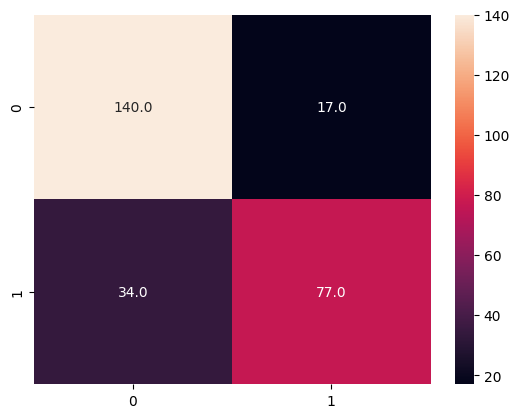

In [50]:
from catboost import CatBoostClassifier

#iterations=50, learning_rate=0.1, depth=3,random_seed=0, verbose=0
#iterations=285, learning_rate=0.11949697012050743, depth=3,random_seed=0, verbose=0

params = {"iterations":142, 
            "learning_rate":0.2383291999673536, 
            "depth":8,
            "random_seed":0, 
            "verbose":0}

Cat = CatBoostClassifier(**params)

Cat = train_model(Cat, True)

# Random Forest

[INFO] : cross val score...
Cross-validation scores for each fold: [0.792      0.816      0.776      0.83064516 0.87096774]
Mean CV score: 0.8171225806451613
Standard deviation of CV scores: 0.03288048803220858

[INFO] : train model...
[INFO] : end training

Accuracy :  0.8134328358208955


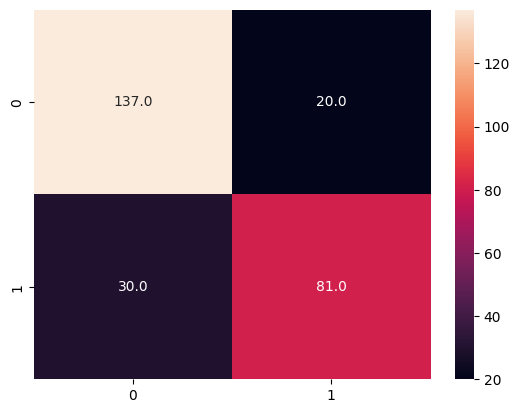

In [51]:
rf = RandomForestClassifier(n_estimators = 100) 

rf = train_model(rf, True)

# Decision tree

[INFO] : cross val score...
Cross-validation scores for each fold: [0.776      0.768      0.752      0.81451613 0.85483871]
Mean CV score: 0.7930709677419355
Standard deviation of CV scores: 0.037099716012387374

[INFO] : train model...
[INFO] : end training

Accuracy :  0.7686567164179104


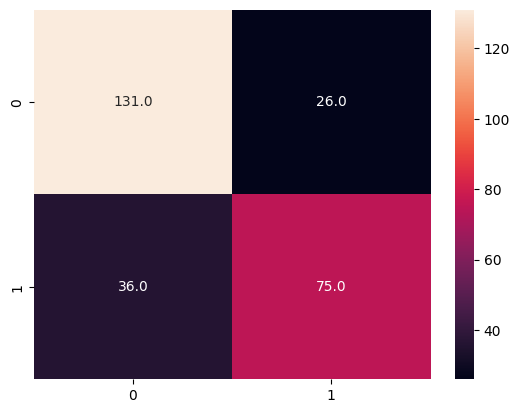

In [53]:
dt = DecisionTreeClassifier(criterion = 'entropy')

dt = train_model(dt, True)

[INFO] : cross val score...
Cross-validation scores for each fold: [0.76       0.832      0.768      0.83870968 0.83064516]
Mean CV score: 0.8058709677419357
Standard deviation of CV scores: 0.03438960228117261

[INFO] : train model...
[INFO] : end training

Accuracy :  0.7835820895522388


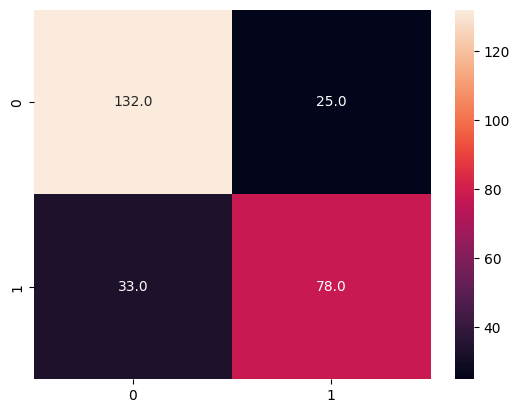

In [54]:
import xgboost as xgb
from xgboost import XGBClassifier

XGB = XGBClassifier()

XGB = train_model(XGB, True)

[INFO] : cross val score...
Cross-validation scores for each fold: [0.824      0.872      0.776      0.83064516 0.83064516]
Mean CV score: 0.8266580645161291
Standard deviation of CV scores: 0.030531917077999803

[INFO] : train model...
[INFO] : end training

Accuracy :  0.7985074626865671


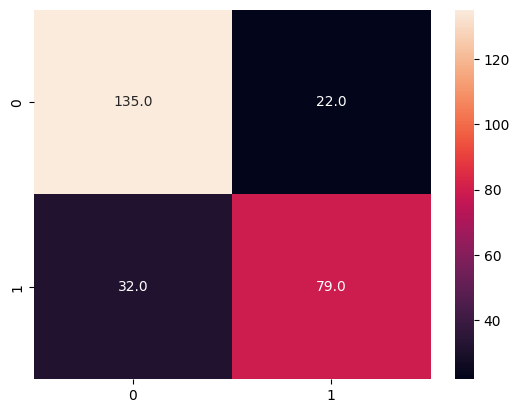

In [55]:
import lightgbm as lgb

# Define model LGBM
LGBM = lgb.LGBMClassifier(verbosity=-1)

LGBM = train_model(LGBM, True)

# II. KNNImputer : new method to fillna

## Summary :
- 1) transform our data like in the first part of this not book without replacing nan values
- 2) labelize our data without replacing Nan values
- 3) the use the KnnImputer function to fillna with nearest neighbors
- 4) model prediction

## 1. Transform data

In [110]:
# When transforming we don't have missing values for cabin anymore because we only keep the "N" of the "Nan" values
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Survived = train.pop("Survived")
Id       = test.PassengerId

train_transform_knn = transfo_titanic(train, False)

test_transform_knn = transfo_titanic(test, False)


[INFO] : transform data...
[INFO] : end transforming
[INFO] : transform data...
[INFO] : end transforming


## 2. Labelize with replacing nan 

### Main function

In [125]:
def encode_data_keep_nan(train: pd.DataFrame, test: pd.DataFrame):
    """
    Label-encodes categorical columns in the DataFrame while preserving NaN values.
    
    Args:
        train (pd.DataFrame): 
            DataFrame with columns to encode.
        
    Returns:
        pd.DataFrame: 
            A DataFrame with label-encoded categorical columns.
    """
    print("[INFO] : labelize data...")
    train_encoded = train.copy()  # Make a copy to avoid modifying the original
    test_encoded = test.copy()  # Make a copy to avoid modifying the original
    
    # Loop through each column in the DataFrame
    for col in train_encoded.select_dtypes(include=['object', 'category']).columns:
        
        print("labelize " + col)
        le = LabelEncoder()
        
        # Fit LabelEncoder only on non-null values to preserve NaN
        non_null_train = train_encoded[col].dropna()
        le.fit(non_null_train)
        
        # Transform with LabelEncoder, and leave NaN as NaN
        train_encoded[col] = train_encoded[col].apply(lambda x: le.transform([x])[0] if pd.notna(x) else x)
        test_encoded[col] = test_encoded[col].apply(lambda x: le.transform([x])[0] if pd.notna(x) else x)
        
    print("[INFO] : end labelize ...")
    print()
    return train_encoded, test_encoded


### We check if have the same number of missing values before and after labelize 

In [111]:
train_transform_knn.isna().sum()

Pclass             0
Sex                0
Age              177
SibSp              0
Parch              0
Fare               0
Embarked           2
Cabin_Prefix       0
Ticket_Prefix      0
Title              0
dtype: int64

In [112]:
test_transform_knn.isna().sum()

Pclass            0
Sex               0
Age              86
SibSp             0
Parch             0
Fare              1
Embarked          0
Cabin_Prefix      0
Ticket_Prefix     0
Title             0
dtype: int64

In [113]:
kt_train, kt_test = encode_data_keep_nan(train_transform_knn, test_transform_knn)

[INFO] : labelize data...
labelize Sex
labelize Embarked
labelize Cabin_Prefix
labelize Ticket_Prefix
labelize Title
[INFO] : end labelize ...



In [114]:
kt_train.isna().sum()

Pclass             0
Sex                0
Age              177
SibSp              0
Parch              0
Fare               0
Embarked           2
Cabin_Prefix       0
Ticket_Prefix      0
Title              0
dtype: int64

In [115]:
kt_test.isna().sum()


Pclass            0
Sex               0
Age              86
SibSp             0
Parch             0
Fare              1
Embarked          0
Cabin_Prefix      0
Ticket_Prefix     0
Title             0
dtype: int64

## 3. KnnImputer

In [116]:
from sklearn.impute import KNNImputer

imputer = KNNImputer()
    
train_knn = pd.DataFrame(imputer.fit_transform(kt_train), columns = [i for i in kt_train])
test_knn  = pd.DataFrame(imputer.transform(kt_test), columns = [i for i in kt_test])

In [117]:
train_knn.isna().any()

Pclass           False
Sex              False
Age              False
SibSp            False
Parch            False
Fare             False
Embarked         False
Cabin_Prefix     False
Ticket_Prefix    False
Title            False
dtype: bool

# 4. Model prediction

In [118]:
# We split

x_train, x_val, label_train, label_val = train_test_split(train_knn, Survived, test_size = 0.3, random_state = 42)
print("len x_train: ",x_train.shape)
print("len x_val: ", x_val.shape)
print("len label_train: ",label_train.shape)
print("len label_val: ", label_val.shape)


len x_train:  (623, 10)
len x_val:  (268, 10)
len label_train:  (623,)
len label_val:  (268,)


# Regression

[INFO] : cross val score...
Cross-validation scores for each fold: [0.76       0.896      0.768      0.72580645 0.80645161]
Mean CV score: 0.7912516129032259
Standard deviation of CV scores: 0.05831575181260465

[INFO] : train model...
[INFO] : end training

Accuracy :  0.8171641791044776


/Users/avicenne/anaconda3/envs/ultra/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/avicenne/anaconda3/envs/ultra/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

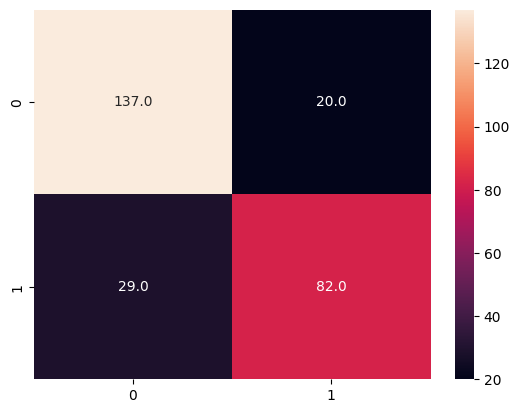

In [120]:
clf = LogisticRegression()

clf = train_model(clf, True)

# Random forest

[INFO] : cross val score...
Cross-validation scores for each fold: [0.792      0.816      0.784      0.83870968 0.86290323]
Mean CV score: 0.8187225806451615
Standard deviation of CV scores: 0.02925262317364071

[INFO] : train model...
[INFO] : end training

Accuracy :  0.8097014925373134


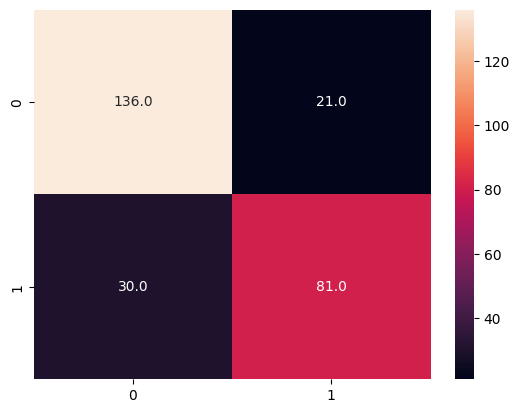

In [121]:
RFC = RandomForestClassifier(n_estimators = 100) 

RFC = train_model(RFC, True)

# Decision Tree

[INFO] : cross val score...
Cross-validation scores for each fold: [0.792      0.76       0.752      0.7983871  0.85483871]
Mean CV score: 0.7914451612903226
Standard deviation of CV scores: 0.03636470599126887

[INFO] : train model...
[INFO] : end training

Accuracy :  0.746268656716418


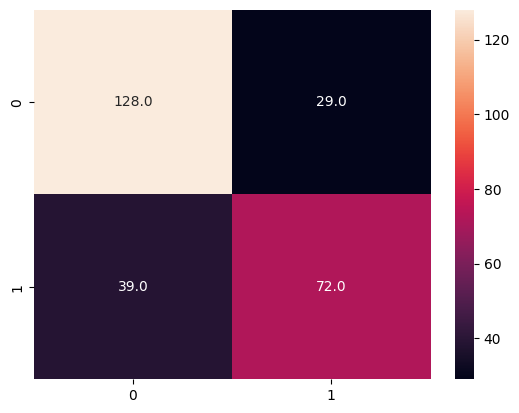

In [122]:
DT = DecisionTreeClassifier(criterion = 'entropy')

DT = train_model(DT, True)

[INFO] : cross val score...
Cross-validation scores for each fold: [0.76       0.832      0.768      0.83870968 0.83064516]
Mean CV score: 0.8058709677419357
Standard deviation of CV scores: 0.03438960228117261

[INFO] : train model...
[INFO] : end training

Accuracy :  0.7835820895522388


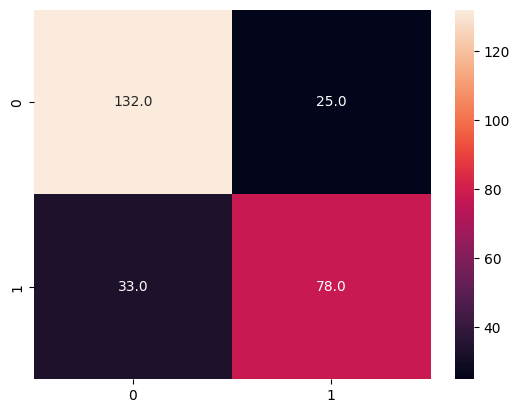

In [123]:
import xgboost as xgb
from xgboost import XGBClassifier

XGB = XGBClassifier()

XGB = train_model(XGB, True)

[INFO] : cross val score...
Cross-validation scores for each fold: [0.824      0.864      0.768      0.82258065 0.83870968]
Mean CV score: 0.8234580645161291
Standard deviation of CV scores: 0.031473546694315374

[INFO] : train model...
[INFO] : end training

Accuracy :  0.7873134328358209


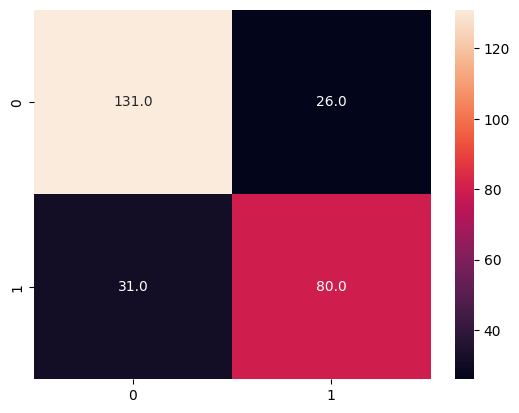

In [124]:
from catboost import CatBoostClassifier

Cat = CatBoostClassifier(iterations=3000,
                        learning_rate=0.1,
                        depth=3,random_seed=0, verbose=0)

Cat = train_model(Cat, True)